# Introduction

In [ ]:
"""
What? k-Nearest Neighbours for classification

https://github.com/amueller/introduction_to_ml_with_python
Guido, Sarah, and Andreas Müller. Introduction to machine learning with python. Vol. 282. O'Reilly Media, 2016.
"""

# Import modules

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.datasets import make_blobs
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
rcParams['figure.figsize'] = 14, 6
rcParams['font.size'] = 20

# Create dataset

In [3]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [4]:
 X, y = make_forge()

In [6]:
print(X.shape, y.shape)

(26, 2) (26,)


# Helper function

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap


cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

# Plot KNN

In [ ]:
"""
It consists only of storing the training dataset. To make a prediction for a new data point, the algorithm
finds the closest data points in the training dataset—its “nearest neighbors.
"""

In [8]:
def plot_knn_classification(n_neighbors=1):

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], clf.predict(X_test), markers="*")
    training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, ["training class 0", "training class 1",
                                               "test pred 0", "test pred 1"])

In [ ]:
"""
In its simplest version, the k-NN algorithm only considers exactly one nearest neigh‐ bor, which is the closest
training data point to the point we want to make a prediction for. The prediction is then simply the known output 
for this training point.
Here, we added three new data points, shown as stars. For each of them, we marked the closest point in the training
set. The prediction of the one-nearest-neighbor algo‐ rithm is the label of that point (shown by the color of the 
cross).
"""

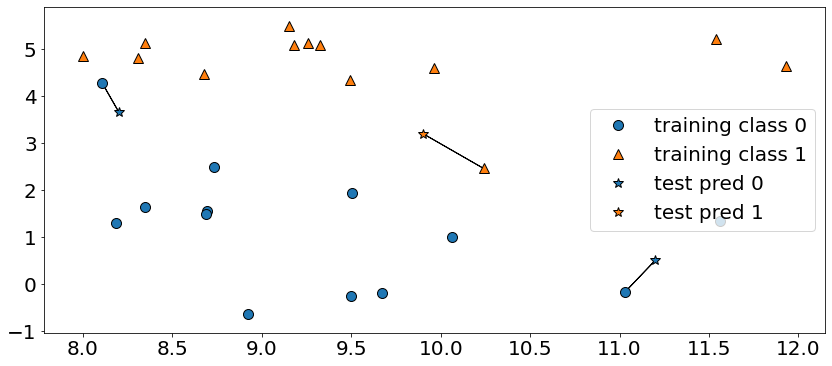

In [13]:
plot_knn_classification(n_neighbors=1)

In [ ]:
"""
When considering more than one neighbor, we use VOTING to assign a label. This means that for each test point, 
we count how many neighbors belong to class 0 and how many neighbors belong to class 1. We then assign the class
that is more frequent: in other words, the majority class among the k-nearest neighbors.
"""

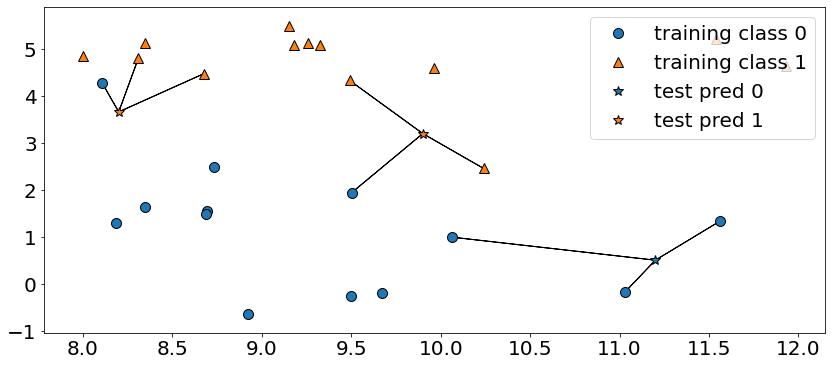

In [15]:
plot_knn_classification(n_neighbors=3)

In [ ]:
"""
Again, the prediction is shown as the color of the cross. You can see that the predic‐ tion for the new data 
point at the top left is not the same as the prediction when we used only one neighbor.
"""

# Applying KNN

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [25]:
print(X.shape, y.shape)
print(X_train.shape)
print(X_test.shape)

(26, 2) (26,)
(19, 2)
(7, 2)


In [27]:
# Instantiate the class
clf = KNeighborsClassifier(n_neighbors=3)

In [ ]:
"""
Now, we fit the classifier using the training set. For KNeighborsClassifier this means storing the dataset, so 
we can compute neighbors during prediction:
"""

In [28]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
"""
To make predictions on the test data, we call the predict method. For each data point in the test set, this 
computes its nearest neighbors in the training set and finds the most common [VIA VOTING] class among these:
"""

In [29]:
print("Test set predictions:", clf.predict(X_test))

Test set predictions: [1 0 1 0 1 0 0]


In [30]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))

Test set accuracy: 0.86


In [ ]:
"""
We see that our model is about 86% accurate, meaning the model predicted the class correctly for 86% of
the samples in the test dataset.
"""

# How many neighbours?

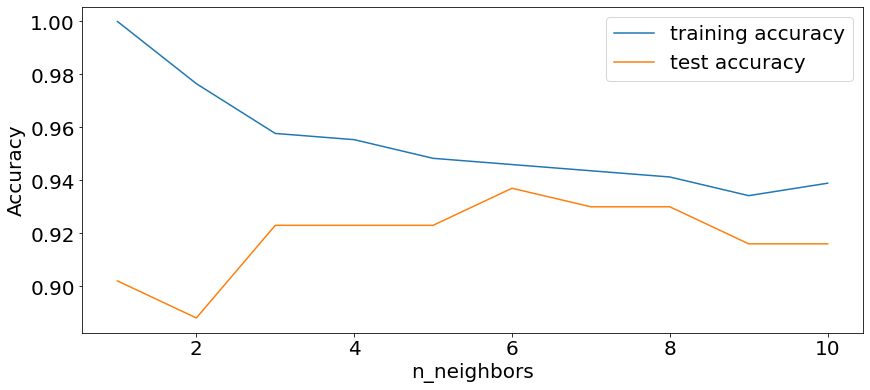

In [37]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=66)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
"""
Considering a single nearest neighbour, the prediction on the training set is perfect. 
But when more neighbours are considered, the model becomes simpler and the training accuracy drops. 
The test set accuracy for using a single neighbour is lower than when using more neighbours, indicating that using
the single nearest neighbuor leads to a model that is too complex. On the other hand, when considering 10 neighbours,
the model is too simple and performance is even worse. 
"""